Per questo notebook, che ha lo scopo di fornire una panoramica su alcuni strumenti legati all'analisi di reti e di fenomeni di diffusione dell'informazione su di esse, utilizzeremo un piccolo dataset famoso nella Network Science: [Zachary's Karate Club](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm).  
La costruzione di questo dataset è legato a una storia interessante e rappresenta uno delle prime applicazioni degli algoritmi di Community Detection, lascio quindi ai più curiosi un riferimento per [approfondire](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

# Introduzione

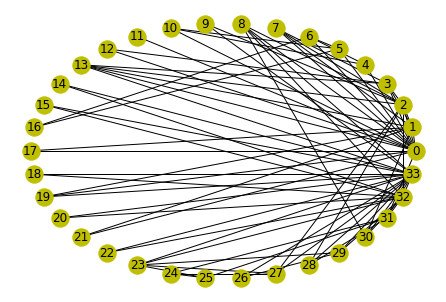

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True,node_color='y')
plt.show()

I nodi possono avere informazione (attributi)

In [2]:
G.nodes[0]

{'club': 'Mr. Hi'}

Posso aggiungere attributi, modificarne i valori, ...

In [3]:
G.nodes[0]['status'] = 'infected'

E colorare in base ad essi la rete

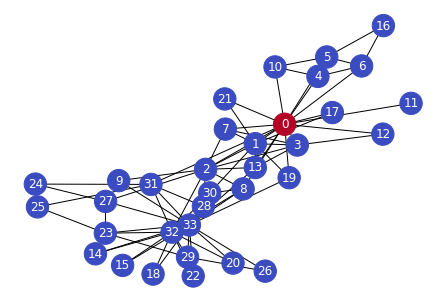

In [4]:
values = [1 if e=='infected' else 0. for e in \
          [G.nodes[i].get('status','susceptible') for i in range(0,len(G.nodes))]]

nx.draw(G, cmap=plt.cm.coolwarm, node_color=values, with_labels=True, font_color='white',node_size=500)
plt.show()

In [5]:
del(G.nodes[0]['status'])

Visualizziamo con una mappa di calore un indice di centralità della rete

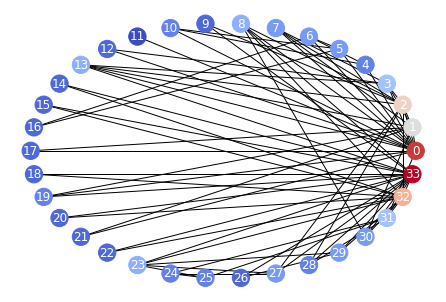

In [6]:
deg_centrality_values = list(nx.degree_centrality(G).values())

nx.draw_circular(G, with_labels=True, node_color=deg_centrality_values, cmap=plt.cm.coolwarm,font_color='white')
plt.show()